We'll first define the inputs to the model. These will be read into the notebook from csv files.

In [2]:
import numpy as np

# Load the origin totals
Oi = np.loadtxt("origin_vect.csv", delimiter=",")
# Load the destination totals
Dj = np.loadtxt("dest_vect.csv", delimiter=",")
# Load the travel time data
tij = np.loadtxt("time_matrix.csv", delimiter=",")

# Basic Gravity Model
We will define a function to handle the iterations. The impedance function is given by $f_{ij}=1/t_{ij}^2$.

## Destination-based Gravity Model

In [72]:
"""
This function maintains the origin constrain
It can be iteratively called to update the destination totals to match destination constraints - i.e., perform a gravity update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def dest_gravity(Oi,Dj,tij):
    Dj_new = Dj
    fij = tij**-2 # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj_new*fij).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Oi[i] * Dj_new * fij[i,:] / denom[i]
    return(Tij)

We will define a loop at continues until all $R_i$ factors are below an $\epsilon$ difference from 1.0 as user-defined (we're use 2%). Let's first setup a check to make sure the basic structure works (not necessary for analysis).

In [73]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model

i = 1 # define an iteration counter

while (max(eps_vector)):
    print("check", i)
    eps_vector=np.abs(eps_vector-0.25)
    i+=1

check 1
check 2
check 3
check 4


Looks good. Now let's define the full gravity model with an iterative call to dest_gravity().

In [74]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions


i = 1 # define an iteration counter

while (max(eps_vector)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = dest_gravity(Oi,Dj_new,tij)
    Rj = Dj/Tij.sum(axis=0)
    eps_vector = np.abs(Rj-1)
    print("Iteration", i)
    print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. epsilon 0.5670812008228296
Iteration 2
Current max. epsilon 0.08755799371670792
Iteration 3
Current max. epsilon 0.032265328217909284
Iteration 4
Current max. epsilon 0.011318911750225258
Final Tij
 [[111.70393815  28.80253239  40.83880459 218.65472487]
 [ 27.30788732 253.48530766 102.23335081  76.97345421]
 [ 13.12639073  51.47978576 291.9705646   43.42325891]
 [108.22482071 128.1372804   89.0253992  376.61249969]]


## Origin-based Gravity Model
The same procedure can be used based on adjusting the origin totals and fixing the destination totals.

In [79]:
"""
This function maintains the origin constraint
It can be iteratively called to update the origin totals to match origin constraints - i.e., perform a gravity update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def origin_gravity(Oi,Dj,tij):
    Oi_new = Oi
    fij = tij**-2 # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Oi_new*fij.transpose()).sum(axis=1) # switch summation dimension from dest_gravity
    # Trips are given by Oi x Dj_new x fij / denom
    for j in range(Oi.shape[0]):
            Tij[:,j] = Oi_new * Dj[j] * fij[:,j] / denom[j]
    return(Tij)

In [80]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while (max(eps_vector)>eps):
#while (i<3):
    if i==1:
        Oi_new = Oi
    else:
        Oi_new = Oi_new*Ri

    Tij = origin_gravity(Oi_new,Dj,tij)
    Ri = Oi/Tij.sum(axis=1) # switch summation dimension from dest_gravity
    eps_vector = np.abs(Ri-1)
    print("Iteration", i)
    print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. epsilon 0.4911429260973377
Iteration 2
Current max. epsilon 0.043847589935050335
Iteration 3
Current max. epsilon 0.00933833244752813
Final Tij
 [[111.80152159  29.76740576  42.7535289  219.44808732]
 [ 26.31120491 252.19502246 103.03029581  74.36820764]
 [ 12.54460336  50.80183754 291.8571873   41.61287524]
 [107.34267015 131.23573424  92.35898799 374.5708298 ]]


## Comparing to Entropy Formulation
We can also use an entropy formulation, which gives the same result as the gravity formulation.

In [81]:
"""
This function maintains the origin constrain
It can be iteratively called to update the destination totals to match destination constraints - i.e., perform an entropy update.
Inputs:
Oi = known origin trip totals by zone
Dj = known destination trip totals by zone
tij = known travel time between origin zone i and destination zone j
Returns:
A 2D array of trip totals by i/j zone pair
"""
def dest_entropy(Oi,Dj,tij):
    Bj = np.ones(Dj.shape[0])
    Ai = 1/Bj
    fij = tij**-2 # The impedance function is given by the inverse of the squared tij travel times
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj*Bj*fij).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Ai*Oi[i] * Dj * fij[i,:] / denom[i]
    return(Tij)

In [82]:
eps = 0.02 # Check against a 2% difference

eps_vector = np.ones(Oi.shape[0]) # Epsilon vector to be updated as we run the gravity model
Tij = np.ones(tij.shape) # Define a container to store OD trip data that has the correct dimensions


i = 1 # define an iteration counter

while (max(eps_vector)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = dest_entropy(Oi,Dj_new,tij)
    Rj = Dj/Tij.sum(axis=0)
    eps_vector = np.abs(Rj-1)
    print("Iteration", i)
    print("Current max. epsilon", max(eps_vector))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. epsilon 0.5670812008228296
Iteration 2
Current max. epsilon 0.08755799371670792
Iteration 3
Current max. epsilon 0.032265328217909284
Iteration 4
Current max. epsilon 0.011318911750225258
Final Tij
 [[111.70393815  28.80253239  40.83880459 218.65472487]
 [ 27.30788732 253.48530766 102.23335081  76.97345421]
 [ 13.12639073  51.47978576 291.9705646   43.42325891]
 [108.22482071 128.1372804   89.0253992  376.61249969]]


# Biproportional Updating
Another common task that can benefit from a "gravity style" approach is biproportional updating to match future O-D trip matrices. Let's define a base year table that we will then update using this approach.

## Gravity-Style Update

In [101]:
Tij_base = np.random.randint(50,150,size=(Oi.shape[0],Dj.shape[0]))

In [102]:
def biprop_gravity(Oi, Dj, Tij_base):
    Dj_new = Dj
    
    # Denominator of gravity expression = element-wise sum D_j x f_ij across columns
    denom = (Dj_new*Tij_base).sum(axis=1)
    Tij = np.ones((Oi.shape[0],Dj.shape[0])) # Define an array with correct dimensions to update
    # Trips are given by Oi x Dj_new x fij / denom
    for i in range(Oi.shape[0]):
            Tij[i,:] = Oi[i] * Dj_new * Tij_base[i,:] / denom[i]
    return(Tij)

In [103]:
eps = 1.001 # Check against a 0.1% difference

Rj = 10*np.ones(Oi.shape[0]) # Rj vector to be updated as we run the gravity model
Tij = Tij_base # Define a container to store OD trip data that has the correct dimensions


i = 1 # define an iteration counter

while (max(Rj)>eps):
    if i==1:
        Dj_new = Dj
    else:
        Dj_new = Dj_new*Rj
        
    Tij = biprop_gravity(Oi,Dj_new,Tij_base)
    Rj = Dj/Tij.sum(axis=0)
    print("Iteration", i)
    print("Current max. Rj", max(Rj))
    i+=1
print("Final Tij\n", Tij)

Iteration 1
Current max. Rj 1.2653690523126606
Iteration 2
Current max. Rj 1.0032909314572804
Iteration 3
Current max. Rj 1.000076864191593
Final Tij
 [[ 69.34221172  90.89461968 103.39006797 136.37310063]
 [ 39.11986795 105.47006627 107.15458382 208.25548196]
 [ 45.76930662 100.00530948  90.14312984 164.08225406]
 [103.79032649 167.63014475 229.34493479 201.23459397]]


## Row/Column (Iterative Proportional Updating)
A common and very useful technique for updating a trip matrix is called *iterative proportional updating*, or IPF. In this approach, we iterate between adjusting cell totals to match row totals, then column totals, etc.

In [104]:
def ipf(Tij,Oi,Di,i):
    if i%2==1: # If it's an add iteration then balance row totals
        R = Oi/Tij.sum(axis=1)
        Tij =  Tij*R[:,np.newaxis] # Need to add dimension so the multiplication occurs across rows not columns
    else: # If it's an odd even iteration then balance column totals
        R = Dj/Tij.sum(axis=0)
        Tij =  Tij*R # Do not add dimension so the multiplication occurs across columns not rows
    print(Tij,R)
    
    return (Tij, R)
    

In [105]:
eps = 1.001 # Check against a 0.1% difference

Ri = 10*np.ones(Oi.shape[0]) # Ri vector to be updated as we run the gravity model
Rj = 10*np.ones(Dj.shape[0]) # Rj vector to be updated as we run the gravity model

Tij = Tij_base # Define a container to store OD trip data that has the correct dimensions

i = 1 # define an iteration counter

while ((max(Ri)>eps) and (max(Rj)>eps)):
    if i%2==1: # If it's an odd iteration then balance row totals
        Tij, Ri = ipf(Tij,Oi,Dj,i) 
    else: # If it's an even iteration then balance column totals
        Tij, Rj = ipf(Tij,Oi,Dj,i)

    print("Iteration", i)
    print("Current max. Ri", max(Ri))
    print("Current max. Rj", max(Rj))
    i+=1
print("Final Tij\n", Tij)

[[112.45283019 110.18867925 106.41509434  70.94339623]
 [ 71.19047619 143.47619048 123.76190476 121.57142857]
 [ 79.47019868 129.8013245   99.33774834  91.39072848]
 [165.89048991 200.28242075 232.65129683 103.17579251]] [0.75471698 1.0952381  1.32450331 2.02305476]
Iteration 1
Current max. Ri 2.0230547550432276
Current max. Rj 10.0
[[ 67.62834502  87.58487105 100.32623026 130.12719902]
 [ 42.81345412 114.04387209 116.68049003 222.9911496 ]
 [ 47.79282128 103.17423121  93.65383619 167.6325091 ]
 [ 99.76537958 159.19702564 219.33944352 189.24914228]] [0.601393   0.7948627  0.94278195 1.83423977]
Iteration 2
Current max. Ri 2.0230547550432276
Current max. Rj 1.8342397734663856
[[ 70.1417619   90.839975   104.05486859 134.96339452]
 [ 39.66372609 105.65381835 108.09646386 206.5859917 ]
 [ 46.3722764  100.10758603  90.87016548 162.64997208]
 [104.91377798 167.41239771 230.65846868 199.01535563]] [1.03716514 0.92643135 0.97027702 1.05160506]
Iteration 3
Current max. Ri 1.0516050600523887
Cu

# Goodness of Fit (GoF) Analysis
We'll work with a new set of trip data for the GoF analysis.

In [38]:
# Load the observed data
Tij_obs = np.loadtxt("obs_matrix.csv", delimiter=",")
# Load the predicted data
Tij_pred = np.loadtxt("pred_matrix.csv", delimiter=",")
# Load the travel time data
Tij_TT = np.loadtxt("tlfd_time_matrix.csv", delimiter=",")

## $R^2$ Determination
$R^2 = 1 - \sum_i\sum_j(T_{ij}obs-T_{ij}pred)^2/\sum_i\sum_j (T_{ij}obs-T_{0})^2$

In [19]:
To = Tij_obs.sum()/Tij_obs.size
R2 = 1 - ((Tij_obs - Tij_pred)**2).sum() / ((Tij_obs - To)**2).sum()
print("R2",R2)

R2 0.7992923596393549


## $\chi^2$ Determination
$\chi^2 = \sum_i\sum_j((T_{ij}obs-T_{ij}pred)^2/T_{ij}pred)$

In [31]:
from scipy.stats import chi2

chi_2 = ((Tij_obs - Tij_pred)**2 / Tij_pred).sum()
df = Tij_obs.size - 1 # We have no. of observations minus one (because chi2 is a variance measure and takes up on df with differencing) degrees of freedom
chi_2_test = chi2.ppf(0.95, df)
print("chi2",chi_2, "chi2 test statistic", chi_2_test)

chi2 49.44138306440484 chi2 test statistic 36.41502850180731


### Mean Absolute Error Determination
$MAE = \sum_i\sum_j |T_{ij}obs-T_{ij}pred|/n^2$

In [33]:
MAE = np.abs(Tij_obs - Tij_pred).sum() / Tij_obs.size
print("MAE",MAE)

MAE 4.72


## Normalized $\phi$
$\sum_i\sum_j(T_{ij}obs-T)|ln(T_{ij}obs/T_{ij}pred)|$

In [37]:
NORM_PHI = (Tij_obs / Tij_obs.sum() * np.abs(np.log(Tij_obs / Tij_pred))).sum()
print("NORM_PHI", NORM_PHI)

NORM_PHI 0.23887573051081798


## Trip Length Distribution
We can start by "stacking" the tables from matrices into vectors

In [39]:
Tij_obs_vect = np.reshape(Tij_obs,-1)
Tij_pred_vect = np.reshape(Tij_pred,-1)
Tij_TT_vect = np.reshape(Tij_TT,-1)

We can then take the result, combine it into a 2D array (i.e., matrix), and sort the values by travel times (assume travel time is the first column).

In [51]:
comb_matrix = np.vstack((Tij_TT_vect,Tij_pred_vect,Tij_obs_vect)).T # np.hstack() won't work with C-style vectors because row major, so use np.vstack() and transpose
comb_matrix = comb_matrix[comb_matrix[:, 0].argsort()] # Sort by the 0th column values
print(comb_matrix)

[[ 3.54 36.   24.  ]
 [ 7.   11.   15.  ]
 [ 7.74  7.    7.  ]
 [ 9.   40.   41.  ]
 [11.   52.   50.  ]
 [11.   10.   14.  ]
 [11.   25.   36.  ]
 [12.5   9.   12.  ]
 [13.   21.   30.  ]
 [13.65  6.    6.  ]
 [14.6  36.   45.  ]
 [15.   19.   21.  ]
 [16.   12.    9.  ]
 [19.    9.    5.  ]
 [24.    9.   13.  ]
 [24.   39.   36.  ]
 [28.5   7.    5.  ]
 [29.   22.   18.  ]
 [29.   29.   22.  ]
 [31.    6.    3.  ]
 [32.   13.   25.  ]
 [33.   27.   24.  ]
 [34.   18.   12.  ]
 [35.   13.    3.  ]
 [41.   12.   12.  ]]


We want to calculate the cumulative frequency for both observed and predicted values. It would also be nice to have everything in a Pandas ```Dataframe``` with column names.

In [57]:
import pandas as pd
df = pd.DataFrame(data=comb_matrix,columns=["travel_time","pred_freq","obs_freq"])
df['cum_obs'] = (df["obs_freq"].cumsum()/df["obs_freq"].sum())*100
df['cum_pred'] = (df["pred_freq"].cumsum()/df["pred_freq"].sum())*100
df

,travel_time,pred_freq,obs_freq,cum_obs,cum_pred
0,3.54,36.0,24.0,4.918033,7.377049
1,7.00,11.0,15.0,7.991803,9.631148
2,7.74,7.0,7.0,9.426230,11.065574
3,9.00,40.0,41.0,17.827869,19.262295
4,11.00,52.0,50.0,28.073770,29.918033
5,11.00,10.0,14.0,30.942623,31.967213
6,11.00,25.0,36.0,38.319672,37.090164
7,12.50,9.0,12.0,40.778689,38.934426
8,13.00,21.0,30.0,46.926230,43.237705
9,13.65,6.0,6.0,48.155738,44.467213


We can now plot these values using Matplotlib

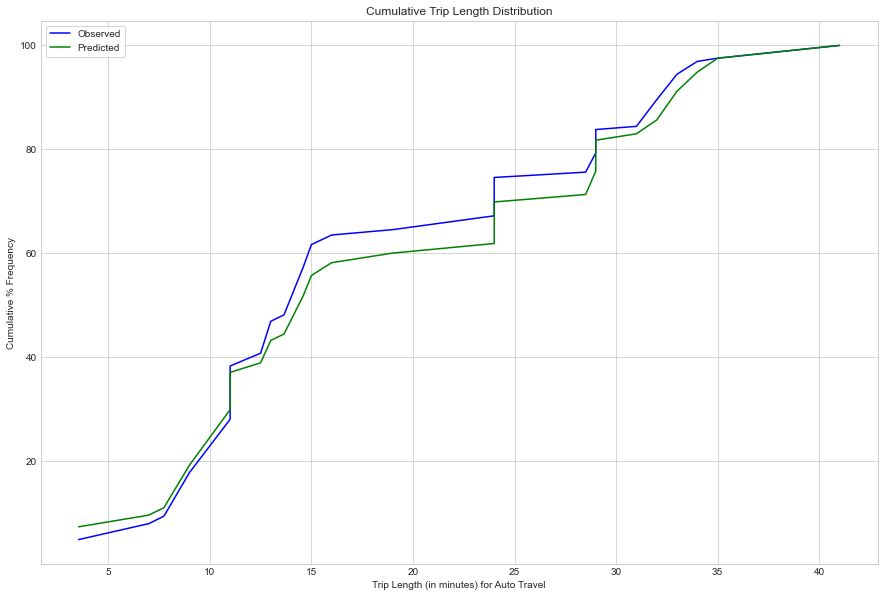

In [69]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(df['travel_time'], df['cum_obs'], '-b', label='Observed')
ax.plot(df['travel_time'], df['cum_pred'], '-g', label='Predicted')
ax.legend(loc='upper left', frameon=True);

plt.xlabel('Trip Length (in minutes) for Auto Travel')
plt.ylabel('Cumulative % Frequency')
plt.title('Cumulative Trip Length Distribution');